# Imports

In [1]:
# if this is your first time running this notebook, uncomment and run the following commands:

# !python -m spacy download nl_core_news_sm
# !python -m spacy download nl_core_news_md
# !python -m spacy download nl_core_news_lg
# !pip install spacy
# !pip install spacy[transformers]
# !pip install spacy-lookups-data

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import spacy
import os
import random
import thinc
import warnings
import spacy.training.loop
from spacy import displacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin, Doc
from spacy.training import Example
from spacy.training.loop import train
from spacy.training.example import Example
from spacy.training.initialize import init_nlp
from spacy.util import minibatch
from spacy.util import registry, minibatch
from pathlib import Path
from collections import Counter
from transformers import logging

# Visualize Spans

In [3]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("data\\training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

In [4]:
colors = {
    "Vastgoed": "#8bc34a",  # Green
    "Ondernemingen": "#2196f3",  # Blue
    "Arbeid": "#ffeb3b",  # Yellow
    "Aansprakelijkheid & Letselschade": "#f44336",  # Red
}

In [5]:
options = {
    "spans_key": "sc",  # Adjust if your span key is different
    "colors": colors
}

displacy.render(docs[0], style="span", options=options, jupyter=True)

In [6]:
for i, doc in enumerate(docs[:5]):
    print(f"\nDoc {i+1}:")
    displacy.render(doc, style="span", options=options, jupyter=True)


Doc 1:



Doc 2:



Doc 3:



Doc 4:



Doc 5:


# Plotting Span Length Frequency

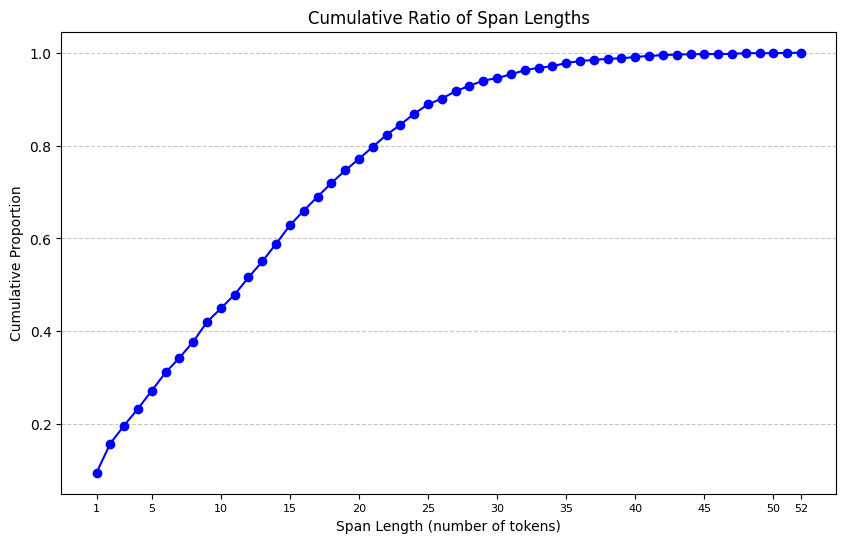

In [7]:
#Obtain the frequency per span length
span_lengths = []
for doc in docs:
    for span in doc.spans.get("sc", []):
        span_lengths.append(len(span))
span_length_counts = np.bincount(span_lengths, minlength=max(span_lengths) + 1)

# Calculate the cumulative sum
cumulative_counts = np.cumsum(span_length_counts)

# Convert to ratio
total_spans = len(span_lengths)
cumulative_ratio = cumulative_counts / total_spans

# Plot cumulative ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_ratio)), cumulative_ratio[1:], marker='o', linestyle='-', color='b')
plt.xlabel('Span Length (number of tokens)')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Ratio of Span Lengths')
plt.xticks(sorted(set([1] + list(range(5, max(span_lengths) + 1, 5)) + [max(span_lengths)])), fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("Span Lengths.png", dpi=300)
plt.show()

In [8]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.9
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.9: 26


In [9]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.75
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.75: 20


# Tuning SpanCat Models per Label

We tune 4 seperate models, one for each label. This is done such that, in the next phase of the project, training data can be added for specific labels when domain experts only provide feedback for one label instead of all. <br>

We keep 15\% of the data for testing purpuses. <br>

We would like to tune the following hyperparameters: <br>

- best decision threshold. We test for 0.05, 0.10 and 0.15
- Number of epochs to avoid overfitting. We test for 10, 25 and 40 epochs
- n value (for ngrams), We test for 20 and 26 (including and excluding 1)
- nl_core_news_lg vs nl_core_news_md (afterwards)

We do this by calculating performance on validation set (called development set in NLP) and selecting the best one

First of all, let us define 3 functions, one for displaying the span scores, one for calculating the peformance metric given a model and one for tuning the model.

In [10]:
def display_span_scores(nlp, text, spans_key="sc"):
    """..."""
    doc = nlp.make_doc(text)
    spancat = nlp.get_pipe("spancat")
    predictions = spancat.predict([doc])
    spancat.set_annotations([doc], predictions)
    
    labels = spancat.labels
    pred_spans = predictions[0].data.tolist()
    pred_scores = predictions[1].data.tolist()
    
    for (start, end), span_scores in zip(pred_spans, pred_scores):
        span_text = doc[start:end].text
        for label, score in zip(labels, span_scores):
            print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

In [11]:
def evaluate_spancat(nlp, examples, threshold=0.05, spans_key="sc"):
    """..."""
    spancat = nlp.get_pipe("spancat")
    labels = spancat.labels
    
    total_tp, total_fp, total_fn = 0, 0, 0
    overlap_scores = []
    soft_tp_total = 0
    pred_span_total = 0
    
    for ex in examples:
        doc = ex.predicted
        gold_doc = ex.reference

        # Predict spans for the doc
        predictions = spancat.predict([doc])
        pred_spans = predictions[0].data.tolist()
        pred_scores = predictions[1].data.tolist()

        pred_spans_with_labels = []
        for (start, end), scores in zip(pred_spans, pred_scores):
            for label, score in zip(labels, scores):
                if score >= threshold:
                    pred_spans_with_labels.append((start, end, label))

        # Gold spans
        gold_spans_with_labels = [(span.start, span.end, span.label_) for span in gold_doc.spans.get(spans_key, [])]

        # F1 components
        tp = 0
        matched_golds = set()

        for ps in pred_spans_with_labels:
            if ps in gold_spans_with_labels:
                tp += 1
                matched_golds.add(ps)
        
        fp = len(pred_spans_with_labels) - tp
        fn = len(gold_spans_with_labels) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Overlap score per predicted span
        for ps in pred_spans_with_labels:
            best_overlap = 0
            for gs in gold_spans_with_labels:
                if ps[2] != gs[2]:  # labels don't match
                    continue
                pred_start, pred_end = ps[0], ps[1]
                gold_start, gold_end = gs[0], gs[1]
                overlap = max(0, min(pred_end, gold_end) - max(pred_start, gold_start))
                union = max(pred_end, gold_end) - min(pred_start, gold_start)
                overlap_ratio = overlap / union if union > 0 else 0
                if overlap_ratio > best_overlap:
                    best_overlap = overlap_ratio
            overlap_scores.append(best_overlap)

        # Soft match: any overlap at all with a gold span of the same label
        for ps in pred_spans_with_labels:
            for gs in gold_spans_with_labels:
                if ps[2] != gs[2]:
                    continue
                pred_start, pred_end = ps[0], ps[1]
                gold_start, gold_end = gs[0], gs[1]
                if max(0, min(pred_end, gold_end) - max(pred_start, gold_start)) > 0:
                    soft_tp_total += 1
                    break  # Don't count the same predicted span more than once
        pred_span_total += len(pred_spans_with_labels)

    # Core metrics
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Custom metrics
    mean_max_overlap = sum(overlap_scores) / len(overlap_scores) if overlap_scores else 0.0
    soft_precision = soft_tp_total / pred_span_total if pred_span_total > 0 else 0.0
    soft_precision
    return {"precision": precision, "recall": recall, "f1": f1, "mean_max_overlap": mean_max_overlap, "soft_precision": soft_precision}

In [12]:
def tune_spancat_model_3(language_model: str = "nl_core_news_lg", 
                         max_epochs: int = 75,
                         tuning_class: str = "Vastgoed", 
                         thresholds: list = [0.05, 0.10, 0.15],
                         ngram_sizes: list = [(1, 21), (2, 21), (1, 27), (2, 27)],
                         save_plots: bool = True):
    """..."""
    random_seed = 8479220
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Check if tuning_class is valid and if the training data is present
    if not tuning_class in ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]:
        raise ValueError('Invalid input data. Please ensure tuning_class ∈ ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]')

    #Create a function to plot the results, we do this now so this is only done once.
    if save_plots:
        def save_train_val_plot(train_scores, val_scores, threshold, ngram_size, tuning_class):

            output_dir= os.path.join("SpanCat results with feature vectors", tuning_class, language_model)
            os.makedirs(output_dir, exist_ok=True)
            epochs = list(train_scores.keys())
        
            plt.figure(figsize=(8, 5))
            plt.plot(epochs, [train_scores[e] for e in epochs], label="Train", marker="o")
            plt.plot(epochs, [val_scores[e] for e in epochs], label="Validation", marker="o")
            plt.xlabel("Epoch")
            plt.ylabel("Mean Max Overlap")
            plt.ylim(0, 1)
            plt.title(f"{tuning_class} | Thr={threshold} | Ngram={ngram_size[0]}-{ngram_size[1]-1}")
            plt.legend()
            plt.grid(True)
        
            filename = f"{tuning_class}_thr{threshold}_ng{ngram_size[0]}-{ngram_size[1]}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)
            plt.close()
    
    print("Beginning to tune model, this may take some time \n\n")
    best_val_score = -1 # Any valid validation score is higher than -1, so this value is always replaced after the first iteration of the nested for loop below.
    best_model = None
    best_params = None

    lang_model = spacy.load(language_model)
    doc_bin = DocBin().from_disk(f"data\\Spancat_training_data_{language_model[-2:]}/{tuning_class}.spacy")
    docs = list(doc_bin.get_docs(lang_model.vocab))

    # Create Example objects directly from the docs
    train_data = [Example(d, d) for d in docs]
    
    # Shuffle all examples
    random.shuffle(train_data)
    
    # Calculate split points
    total = len(train_data)
    train_split = int(total * 0.7)
    dev_split = int(total * 0.85)
    
    # Split data
    train_examples = train_data[:train_split]
    dev_examples = train_data[train_split:dev_split]
    test_examples = train_data[dev_split:]
    
    #Initialize the tuning loop
    for ngram_size in ngram_sizes:

        print(f"\nTuning for ngram_size = [{ngram_size[0]}, {ngram_size[1]}).")

        # Reset the model by taking the unused language model and Add the spancat component
        nlp = spacy.load(language_model, exclude=["ner"])

        # Add tok2vec using pretrained embeddings (uses word vectors from 'md' or 'lg')
        tok2vec_config = {
            "@architectures": "spacy.Tok2Vec.v2",
            "embed": {
                "@architectures": "spacy.MultiHashEmbed.v2",
                "width": 96,
                "attrs": ["ORTH", "LOWER", "PREFIX", "SUFFIX", "SHAPE"],
                "rows": [5000, 2500, 1000, 1000, 500]
            },
            "encode": {
                "@architectures": "spacy.MaxoutWindowEncoder.v2",
                "width": 96,
                "depth": 2,
                "window_size": 1,
                "maxout_pieces": 3
            }
        }

        # SpanCategorizer with tok2vec model
        spancat = nlp.add_pipe("spancat", config={
            "spans_key": "sc",
            "model": {
                "@architectures": "spacy.SpanCategorizer.v1",
                "tok2vec": tok2vec_config
            },
            "suggester": {
                "@misc": "spacy.ngram_suggester.v1",
                "sizes": [i for i in range(ngram_size[0], ngram_size[1])]
            },
            "threshold": 0.0
        }, last=True)
        
        # Define the chosen label and initialize the model
        spancat.add_label(tuning_class)
        np.random.seed(random_seed)
        optimizer = nlp.initialize()
        train_scores = {thr: {} for thr in thresholds}
        val_scores = {thr: {} for thr in thresholds}
        val_soft_precisions = {thr: {} for thr in thresholds}
        
        # Training loop
        for i in range(max_epochs):
            local_random = random.Random(883821973 + i)
            local_random.shuffle(train_examples)

            losses = {}
        
            # Use minibatch training for efficiency
            batches = minibatch(train_examples, size=8)
            for batch in batches:
                nlp.update(batch, sgd=optimizer, losses=losses)

            # To reduce runtime even further, we only check the performance every 5 epochs
            if ((i + 1) % 5 == 0) or (i == max_epochs - 1):
                # Predict docs once for all thresholds
                pred_train_docs = [nlp(example.reference.text) for example in train_examples]
                pred_dev_docs = [nlp(example.reference.text) for example in dev_examples]
                train_preds = [Example(p, r.reference) for p, r in zip(pred_train_docs, train_examples)]
                dev_preds = [Example(p, r.reference) for p, r in zip(pred_dev_docs, dev_examples)]
    
                for threshold in thresholds:
                    train_score = evaluate_spancat(nlp, train_preds, threshold=threshold)["mean_max_overlap"]
                    train_scores[threshold][i+1] = train_score
                    
                    val_metrics = evaluate_spancat(nlp, dev_preds, threshold=threshold)
                    val_score = val_metrics["mean_max_overlap"]
                    val_scores[threshold][i+1] = val_score
                    
                    val_soft_precision = val_metrics["soft_precision"]
                    val_soft_precisions[threshold][i+1] = val_soft_precision

                print(f"Completed epoch {i+1}/{max_epochs}")

            #REMOVE ME AND THE 2 LINES BELOW ME, THIS WAS JUST TO CHECK IF IT WORKS
            # print(epoch_scores_train)
            # print(epoch_scores_val)

        # Save plots and track best model
        for threshold in thresholds:
            if save_plots:
                save_train_val_plot(train_scores[threshold], val_scores[threshold], threshold, ngram_size, tuning_class)

            best_epoch_val = max(val_scores[threshold], key=val_scores[threshold].get)
            best_val = val_scores[threshold][best_epoch_val]
            best_soft_precision = val_soft_precisions[threshold][best_epoch_val]
            print(f"ngram={ngram_size}, threshold={threshold} → Best Mean Max Overlap on val set at epoch {best_epoch_val}: {best_val:.4f} (Soft Precision = {best_soft_precision})")

            if best_val > best_val_score:
                best_val_score = best_val
                best_model = copy.deepcopy(nlp)
                best_params = {
                    "threshold": threshold,
                    "epoch_value": best_epoch_val,
                    "ngram_size": ngram_size
                }

    print(f"\nBest parameter combination:")
    print(f"Threshold: {best_params['threshold']}")
    print(f"Epoch: {best_params['epoch_value']}")
    print(f"Ngram Size: {best_params['ngram_size'][0]}-{best_params['ngram_size'][1]}")

    # test_scores = evaluate_spancat(best_model, test_examples, threshold=best_params["threshold"])["mean_max_overlap"]
    # test_mean_max_overlap = test_scores['mean_max_overlap']
    # test_soft_precision = test_scores['soft_precision']
    
    # print(f"\nMean max overlap of the best model on the test set: {test_mean_max_overlap:.4f}")
    # print(f"Soft precision of the best model on the test set: {test_soft_precision:.4f}")

    return best_model

In [13]:
#Since loading the Spacy models gives a warning which is not relevant for our task, we disable warnings in this notebook

warnings.filterwarnings("ignore", message=r"\[W036\] The component 'matcher' does not have any patterns defined")

# Tuning nl_core_news_lg

In [16]:
tune_spancat_model_3(language_model = "nl_core_news_lg", 
                     max_epochs = 75,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 50: 0.2459 (Soft Precision = 0.5441176470588235)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 25: 0.2931 (Soft Precision = 0.6153846153846154)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 25: 0.3151 (Soft Precision = 0.6538461538461539)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 50: 0.3174 (Soft Precision = 0.6129032258064516)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 50: 0.3520 (Soft Prec

In [16]:
tune_spancat_model_3(language_model = "nl_core_news_lg", 
                     max_epochs = 75,
                     tuning_class = "Vastgoed", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 75: 0.2586 (Soft Precision = 0.5517241379310345)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 75: 0.3795 (Soft Precision = 0.7391304347826086)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 75: 0.3008 (Soft Precision = 0.7)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 70: 0.3140 (Soft Precision = 0.5283018867924528)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 70: 0.3402 (Soft Precision = 0.52272

In [17]:
tune_spancat_model_3(language_model = "nl_core_news_lg", 
                     max_epochs = 75,
                     tuning_class = "Arbeid", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 65: 1.0000 (Soft Precision = 1.0)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 70: 0.4209 (Soft Precision = 0.6666666666666666)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 70: 0.4209 (Soft Precision = 0.6666666666666666)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 70: 0.4735 (Soft Precision = 0.75)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 70: 0.4735 (Soft Precision = 0.75)

Tuning for ngr

In [ ]:
tune_spancat_model_3(language_model = "nl_core_news_lg", 
                     max_epochs = 75,
                     tuning_class = "Aansprakelijkheid & Letselschade", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 75: 0.1132 (Soft Precision = 0.1919191919191919)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 75: 0.1930 (Soft Precision = 0.26666666666666666)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 75: 0.2944 (Soft Precision = 0.3333333333333333)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 75: 0.2500 (Soft Precision = 0.25)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 75: 0.2000 (Soft Precision = 0.2)


# Tuning nl_core_news_md

In [19]:
tune_spancat_model_3(language_model = "nl_core_news_md", 
                     max_epochs = 75,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 50: 0.2459 (Soft Precision = 0.5441176470588235)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 25: 0.2931 (Soft Precision = 0.6153846153846154)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 25: 0.3151 (Soft Precision = 0.6538461538461539)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 50: 0.3174 (Soft Precision = 0.6129032258064516)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 50: 0.3520 (Soft Prec

In [20]:
tune_spancat_model_3(language_model = "nl_core_news_md", 
                     max_epochs = 75,
                     tuning_class = "Vastgoed", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 75: 0.2586 (Soft Precision = 0.5517241379310345)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 75: 0.3795 (Soft Precision = 0.7391304347826086)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 75: 0.3008 (Soft Precision = 0.7)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 70: 0.3140 (Soft Precision = 0.5283018867924528)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 70: 0.3402 (Soft Precision = 0.52272

In [21]:
tune_spancat_model_3(language_model = "nl_core_news_md", 
                     max_epochs = 75,
                     tuning_class = "Arbeid", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 65: 1.0000 (Soft Precision = 1.0)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 70: 0.4209 (Soft Precision = 0.6666666666666666)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 70: 0.4209 (Soft Precision = 0.6666666666666666)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 70: 0.4735 (Soft Precision = 0.75)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 70: 0.4735 (Soft Precision = 0.75)

Tuning for ngr

In [22]:
tune_spancat_model_3(language_model = "nl_core_news_md", 
                     max_epochs = 75,
                     tuning_class = "Aansprakelijkheid & Letselschade", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 75: 0.1132 (Soft Precision = 0.1919191919191919)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 75: 0.1930 (Soft Precision = 0.26666666666666666)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 75: 0.2944 (Soft Precision = 0.3333333333333333)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 75: 0.2500 (Soft Precision = 0.25)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 75: 0.2000 (Soft Precision = 0.2)


# Tuning nl_core_news_sm

In [23]:
tune_spancat_model_3(language_model = "nl_core_news_sm", 
                     max_epochs = 75,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 20: 0.1642 (Soft Precision = 0.9230769230769231)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 20: 0.1653 (Soft Precision = 0.8888888888888888)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 70: 0.1289 (Soft Precision = 0.9230769230769231)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 40: 0.1344 (Soft Precision = 0.8333333333333334)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 40: 0.1344 (Soft Prec

In [24]:
tune_spancat_model_3(language_model = "nl_core_news_sm", 
                     max_epochs = 75,
                     tuning_class = "Vastgoed", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/

In [25]:
tune_spancat_model_3(language_model = "nl_core_news_sm", 
                     max_epochs = 75,
                     tuning_class = "Arbeid", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/

In [26]:
tune_spancat_model_3(language_model = "nl_core_news_sm", 
                     max_epochs = 75,
                     tuning_class = "Aansprakelijkheid & Letselschade", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best Mean Max Overlap on val set at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/

Names for performance metrics: <br>
- **Mean Max Overlap**: averages the best overlap per prediction. This is affected by span boundaries though.
- **Soft Precision**: Ratio of predicted spans that overlap a true span. This is not affected by span boundaries.

Find best: <br>

- Number of epochs to avoid overfitting
- n value (for ngrams), check if you can exclude length 1
- best decision threshold
- nl_core_news_lg vs nl_core_news_md (afterwards)
- Also add mBERT, RoBERTa and BERTje to the comparison (so 5 language models)

Eventually, we will need to run the code 20 times (4 classes X 5 models) for 20 hyperparameters (4 n values X 5 thresholds)

Do this by calculating performance (maybe changed to modified F1 instead of modified precision) on validation set (called development set in NLP) and selecting the best one

# Test with transformer models

In [16]:
def tune_spancat_model_4(transformer_model: str = "GroNLP/bert-base-dutch-cased", 
                         max_epochs: int = 75,
                         tuning_class: str = "Vastgoed", 
                         thresholds: list = [0.05, 0.10, 0.15],
                         ngram_sizes: list = [(1, 21), (2, 21), (1, 27), (2, 27)],
                         save_plots: bool = True):
    """Tuning SpanCat model using Transformer embeddings."""
    
    random_seed = 8479220
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    lang_dic = {'GroNLP/bert-base-dutch-cased': 'BERTje', 'bert-base-multilingual-cased': 'mBERT'}
    if not transformer_model in lang_dic:
        raise ValueError('Invalid input. Please ensure transformer_model ∈ ["GroNLP/bert-base-dutch-cased", "bert-base-multilingual-cased"]')
    if tuning_class not in ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]:
        raise ValueError('Invalid input. Please ensure tuning_class ∈ ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]')

    if save_plots:
        def save_train_val_plot(train_scores, val_scores, threshold, ngram_size, tuning_class, output_dir=f"spancat_tuning_plots_{tuning_class}_{lang_dic[transformer_model]}"):
            os.makedirs(output_dir, exist_ok=True)
            epochs = list(train_scores.keys())
        
            plt.figure(figsize=(8, 5))
            plt.plot(epochs, [train_scores[e] for e in epochs], label="Train", marker="o")
            plt.plot(epochs, [val_scores[e] for e in epochs], label="Validation", marker="o")
            plt.xlabel("Epoch")
            plt.ylabel("Mean Max Overlap")
            plt.ylim(0, 1)
            plt.title(f"{tuning_class} | Thr={threshold} | Ngram={ngram_size[0]}-{ngram_size[1]-1}")
            plt.legend()
            plt.grid(True)
        
            filename = f"{tuning_class}_thr{threshold}_ng{ngram_size[0]}-{ngram_size[1]}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)
            plt.close()

    print("Beginning to tune model with Transformer backbone, this may take some time.\n\n")

    best_val_score = -1
    best_model = None
    best_params = None

    # Load the training data
    base_nlp = spacy.blank("nl")  # Blank pipeline, we'll add transformer later
    doc_bin = DocBin().from_disk(f"data\\Spancat_training_data_{lang_dic[transformer_model]}/{tuning_class}.spacy")
    docs = list(doc_bin.get_docs(base_nlp.vocab))
    train_data = [Example(d, d) for d in docs]

    random.shuffle(train_data)
    
    total = len(train_data)
    train_split = int(total * 0.7)
    dev_split = int(total * 0.85)

    train_examples = train_data[:train_split]
    dev_examples = train_data[train_split:dev_split]
    test_examples = train_data[dev_split:]

    # Tuning loop
    for ngram_size in ngram_sizes:
        print(f"\nTuning for ngram_size = [{ngram_size[0]}, {ngram_size[1]}).")

        # Create a fresh blank pipeline
        nlp = spacy.blank("nl")

        # Add transformer component
        transformer = nlp.add_pipe("transformer", config={
            "model": {
                "@architectures": "spacy-transformers.TransformerModel.v3",
                "name": transformer_model,
            }
        })

        # Add SpanCat component
        spancat = nlp.add_pipe("spancat", config={
            "spans_key": "sc",
            "suggester": {
                "@misc": "spacy.ngram_suggester.v1",
                "sizes": [i for i in range(ngram_size[0], ngram_size[1])]
            },
            "threshold": 0.0
        })

        spancat.add_label(tuning_class)

        np.random.seed(random_seed)

        # Initialize weights properly (transformer + spancat)
        optimizer = nlp.initialize(get_examples=lambda: train_examples)

        train_scores = {thr: {} for thr in thresholds}
        val_scores = {thr: {} for thr in thresholds}
        val_soft_precisions = {thr: {} for thr in thresholds}

        # Training loop
        for i in range(max_epochs):
            local_random = random.Random(883821973 + i)
            local_random.shuffle(train_examples)

            losses = {}

            batches = minibatch(train_examples, size=8)
            for batch in batches:
                nlp.update(batch, sgd=optimizer, losses=losses)

            if ((i + 1) % 5 == 0) or (i == max_epochs - 1):
                pred_train_docs = [nlp(example.reference.text) for example in train_examples]
                pred_dev_docs = [nlp(example.reference.text) for example in dev_examples]
                train_preds = [Example(p, r.reference) for p, r in zip(pred_train_docs, train_examples)]
                dev_preds = [Example(p, r.reference) for p, r in zip(pred_dev_docs, dev_examples)]

                for threshold in thresholds:
                    train_score = evaluate_spancat(nlp, train_preds, threshold=threshold)["mean_max_overlap"]
                    train_scores[threshold][i+1] = train_score

                    val_metrics = evaluate_spancat(nlp, dev_preds, threshold=threshold)
                    val_score = val_metrics["mean_max_overlap"]
                    val_scores[threshold][i+1] = val_score

                    val_soft_precision = val_metrics["soft_precision"]
                    val_soft_precisions[threshold][i+1] = val_soft_precision

                print(f"Completed epoch {i+1}/{max_epochs}")

        # Save plots and find best model
        for threshold in thresholds:
            if save_plots:
                save_train_val_plot(train_scores[threshold], val_scores[threshold], threshold, ngram_size, tuning_class)

            best_epoch_val = max(val_scores[threshold], key=val_scores[threshold].get)
            best_val = val_scores[threshold][best_epoch_val]
            best_soft_precision = val_soft_precisions[threshold][best_epoch_val]
            print(f"ngram={ngram_size}, threshold={threshold} → Best val score at epoch {best_epoch_val}: {best_val:.4f} (Soft Precision = {best_soft_precision})")

            if best_val > best_val_score:
                best_val_score = best_val
                best_model = nlp
                best_params = {
                    "threshold": threshold,
                    "epoch_value": best_epoch_val,
                    "ngram_size": ngram_size
                }

    print(f"\nBest parameter combination:")
    print(f"Threshold: {best_params['threshold']}")
    print(f"Epoch: {best_params['epoch_value']}")
    print(f"Ngram Size: {best_params['ngram_size'][0]}-{best_params['ngram_size'][1]}")

    # test_scores = evaluate_spancat(best_model, test_examples, threshold=best_params["threshold"])
    # test_mean_max_overlap = test_scores['mean_max_overlap']
    # test_soft_precision = test_scores['soft_precision']
    
    # print(f"\nMean max overlap of the best model on the test set: {test_mean_max_overlap:.4f}")
    # print(f"Soft precision of the best model on the test set: {test_soft_precision:.4f}")

    return best_model

In [17]:
logging.set_verbosity_error()  # Suppress all warnings and info logs

# BERTje

In [31]:
tune_spancat_model_4(transformer_model = "GroNLP/bert-base-dutch-cased", 
                     max_epochs = 75,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 65: 0.1342 (Soft Precision = 0.39285714285714285)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 55: 0.1686 (Soft Precision = 0.39285714285714285)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 55: 0.1748 (Soft Precision = 0.4074074074074074)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 55: 0.1688 (Soft Precision = 0.4)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 55: 0.1759 (Soft Precision = 0.4166666666666667)

Tuning for ngram_size = [2, 21).
Completed epoch

In [32]:
tune_spancat_model_4(transformer_model = "GroNLP/bert-base-dutch-cased", 
                     max_epochs = 75,
                     tuning_class = "Vastgoed", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 70: 0.1066 (Soft Precision = 0.35802469135802467)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 70: 0.0887 (Soft Precision = 0.23076923076923078)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 70: 0.0142 (Soft Precision = 0.07692307692307693)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 70: 0.0185 (Soft Precision = 0.1)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 70: 0.0231 (Soft Precision = 0.125)

Tuning for ngram_size = [2, 21).
Completed epoch 5/75
Comple

In [33]:
tune_spancat_model_4(transformer_model = "GroNLP/bert-base-dutch-cased", 
                     max_epochs = 75,
                     tuning_class = "Arbeid", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 75: 0.0746 (Soft Precision = 0.24812030075187969)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 75: 0.0573 (Soft Precision = 0.2222222222222222)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 75: 0.0699 (Soft Precision = 0.3333333333333333)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 75: 0.0844 (Soft Precision = 0.14285714285714285)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 75: 0.1970 (Soft Precision = 0.3333333333333333)

Tuning for ngram_size = [2, 21).


In [34]:
tune_spancat_model_4(transformer_model = "GroNLP/bert-base-dutch-cased", 
                     max_epochs = 75,
                     tuning_class = "Aansprakelijkheid & Letselschade", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 2

# mBERT

In [21]:
tune_spancat_model_4(transformer_model = "bert-base-multilingual-cased", 
                     max_epochs = 75,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 55: 0.0810 (Soft Precision = 0.2972972972972973)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 60: 0.0828 (Soft Precision = 0.3508771929824561)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 45: 0.0808 (Soft Precision = 0.2345679012345679)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 45: 0.0690 (Soft Precision = 0.20930232558139536)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 55: 0.0662 (Soft Precision = 0.2962962962962963)

Tuning for ngram_size = [2, 21).
C

In [22]:
tune_spancat_model_4(transformer_model = "bert-base-multilingual-cased", 
                     max_epochs = 75,
                     tuning_class = "Vastgoed", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 2

In [23]:
tune_spancat_model_4(transformer_model = "bert-base-multilingual-cased", 
                     max_epochs = 75,
                     tuning_class = "Arbeid", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 2

In [24]:
tune_spancat_model_4(transformer_model = "bert-base-multilingual-cased", 
                     max_epochs = 75,
                     tuning_class = "Aansprakelijkheid & Letselschade", 
                     thresholds = [0.01, 0.05, 0.10, 0.15, 0.20],
                     ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)],
                     save_plots = True)

Beginning to tune model with Transformer backbone, this may take some time.



Tuning for ngram_size = [1, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 20/75
Completed epoch 25/75
Completed epoch 30/75
Completed epoch 35/75
Completed epoch 40/75
Completed epoch 45/75
Completed epoch 50/75
Completed epoch 55/75
Completed epoch 60/75
Completed epoch 65/75
Completed epoch 70/75
Completed epoch 75/75
ngram=(1, 21), threshold=0.01 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.05 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.1 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.15 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)
ngram=(1, 21), threshold=0.2 → Best val score at epoch 5: 0.0000 (Soft Precision = 0.0)

Tuning for ngram_size = [2, 21).
Completed epoch 5/75
Completed epoch 10/75
Completed epoch 15/75
Completed epoch 2

**NOTE: The input texts are truncated to 512 tokens, so not all data is used!** <br>
Since we rank our models based on an edited version of precision, this is okay for now. But if these models turn out to work best and we want to implement them in the final tool, then it is important to split the data on a paragraph level so that spans are predicted in the whole article.